In [8]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils import basic
from few_shot_learning_system import MAMLFewShotClassifier
import Arbiter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dataset 구성

In [9]:
# choices=['padding', 'random_patch', 'fixed_patch', arbiter],
method = 'arbiter'

datasets = "mini_imagenet"
# datasets = "tiered_imagenet"
# datasets = "CIFAR_FS"
# datasets = "CUB"

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" # https://mtl.yyliu.net/download/Lmzjm9tX.html
# os.environ['TEST_DATASET'] = "CIFAR_FS" # https://drive.google.com/file/d/1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI/view
# os.environ['TEST_DATASET'] = "CUB" # https://data.caltech.edu/records/65de6-vp158

In [10]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML+Arbiter_5way_5shot",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": False,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":48,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "prompter": True,
  "prompt_engineering": method,
  "prompt_size" : 10,
  "image_size" : 84
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


In [11]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)

Using max pooling
meta network params
Inner Loop parameters
Outer Loop parameters
classifier.prompt.prompt_dict.arbiter torch.Size([3, 84, 84]) cuda:0 True
classifier.layer_dict.conv0.conv.weight torch.Size([48, 3, 3, 3]) cuda:0 True
classifier.layer_dict.conv0.conv.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv0.norm_layer.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv0.norm_layer.weight torch.Size([48]) cuda:0 True
classifier.layer_dict.conv1.conv.weight torch.Size([48, 48, 3, 3]) cuda:0 True
classifier.layer_dict.conv1.conv.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv1.norm_layer.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv1.norm_layer.weight torch.Size([48]) cuda:0 True
classifier.layer_dict.conv2.conv.weight torch.Size([48, 48, 3, 3]) cuda:0 True
classifier.layer_dict.conv2.conv.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv2.norm_layer.bias torch.Size([48]) cuda:0 True
classifier.layer_dict.conv2.norm_layer

# 2. Prompt 설정

init_prompt ==  torch.Size([1, 3, 84, 84])


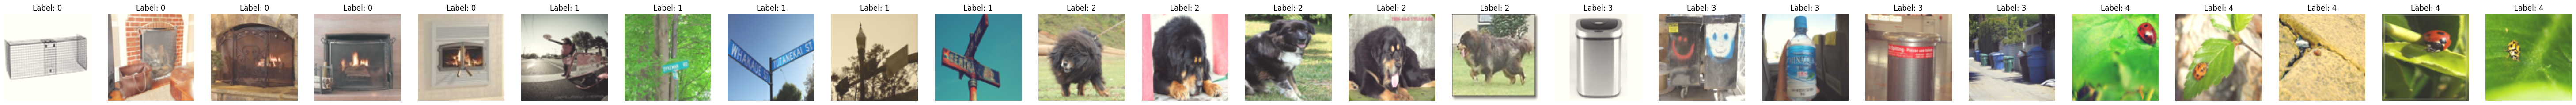

init_prompt ==  torch.Size([1, 3, 84, 84])


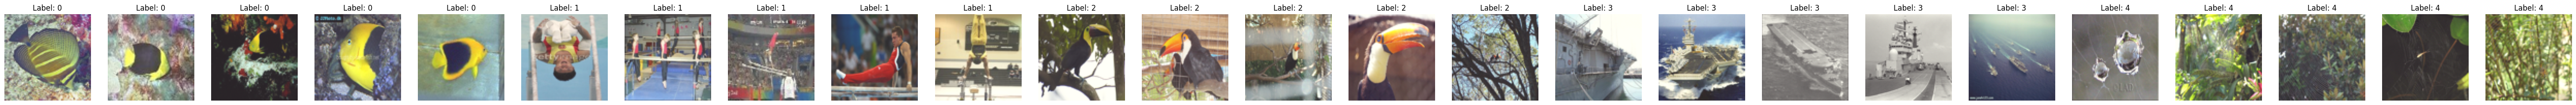

init_prompt ==  torch.Size([1, 3, 84, 84])


KeyboardInterrupt: 

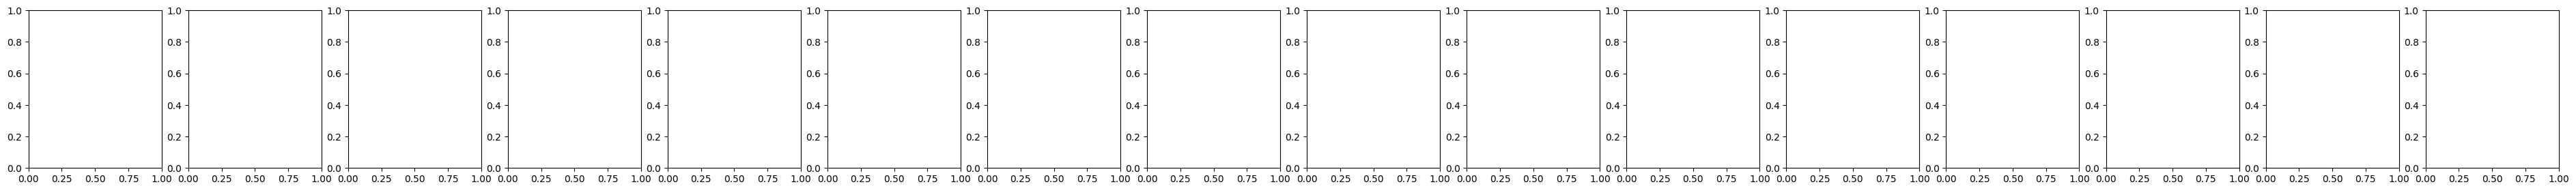

In [16]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/1), augment_images=False)

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
            name.replace('module.', ''): value.unsqueeze(0).repeat(
                [num_devices] + [1 for i in range(len(value.shape))]) for
            name, value in names_weights_copy.items()}

        prompted_weights_copy = {}
        if args.prompter and args.prompt_engineering == 'arbiter':
            prompted_weights_copy = {key: value for key, value in names_weights_copy.items() if 'prompt' in key}

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
        
        task_embeddings = maml_system.model.get_task_embeddings(x_support_set_task=x_support_set_task,
                                                           y_support_set_task=y_support_set_task,
                                                           names_weights_copy=names_weights_copy)
        init_prompt = maml_system.model.arbiter(task_embeddings)
        
        print("init_prompt == ", init_prompt.size())
        
        prompted_images = x_support_set_task + init_prompt
        
        basic.show_batch(images=prompted_images, labels=y_support_set_task, datasets=datasets)
        
        
        # for num_step in range(num_steps):
        